# Занятие 2. Линейная регрессия и не только

Сегодня мы:
* попробуем поработать с данными
* познакомимся с линейной регрессией
* сравним два способа получения параметров:
  1. через аналитическое решение (обращение матрицы)
  2. через градиентный спуск (реализация в sklearn)
* поймём, что такое **оптимальное решение** в задаче линейной регрессии

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn import metrics


**Оптимальное решение** — это такие параметры $\theta = [\theta_0, \theta_1, \dots]$, при которых функция потерь (обычно MSE) достигает **минимума**.

Функция потерь (среднеквадратичная ошибка):

$$ \text{MSE}(\theta) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum_{i=1}^n (y_i - (\theta_0 + \theta_1 x_i))^2 $$

Аналитическое решение (обычная линейная регрессия):

$$ \hat{\theta} = (X^T X)^{-1} X^T y $$

где X — матрица признаков с добавленным столбцом единиц (для $\theta_0$).

Пример как выглядит решение с помощью линейной регрессии

V = I · R + шум

In [2]:
np.random.seed(42)

n = 50
I = np.random.uniform(0, 10, n)          # ток, А
R_true = 9.7                             # настоящее сопротивление
noise = np.random.normal(0, 10, n)      # шум измерения напряжения
V = I * R_true + noise                   # измеренное напряжение

df = pd.DataFrame({'Ток_I': I, 'Напряжение_V': V})
df.head()

,Ток_I,Напряжение_V
0,3.745401,43.715057
1,9.507143,93.932971
2,7.319939,69.846930
3,5.986585,55.058836
4,1.560186,0.348588


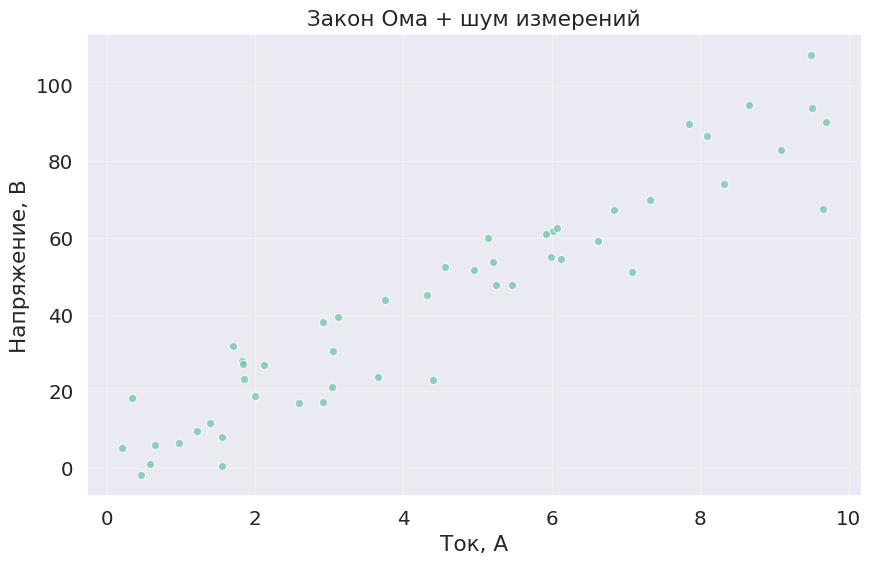

In [3]:
plt.figure(figsize=(10,6))
plt.scatter(df['Ток_I'], df['Напряжение_V'], alpha=0.7, edgecolor='w')
plt.xlabel('Ток, А')
plt.ylabel('Напряжение, В')
plt.title('Закон Ома + шум измерений')
plt.grid(True, alpha=0.3)
plt.show()

Часть данных пойдет на обучение, а часть на проверку, для этого разделим данные

In [4]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

X_train = train[['Ток_I']].values
y_train = train['Напряжение_V'].values

X_test  = test[['Ток_I']].values
y_test  = test['Напряжение_V'].values

## Способ 1. Аналитическое решение (обычная МНК)

In [5]:
# Добавляем столбец единиц для свободного члена
X_train_b = np.c_[np.ones(len(X_train)), X_train]
X_test_b  = np.c_[np.ones(len(X_test)),  X_test]

# Аналитическая формула МНК
theta_best = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train

print(f"Аналитическое решение:\n  theta_0 (intercept) = {theta_best[0]:.4f} В")
print(f"  theta_1 (коэффициент) = {theta_best[1]:.4f} В/А  →  R = {theta_best[1]:.4f} Ом")

Аналитическое решение:
  theta_0 (intercept) = 2.4748 В
  theta_1 (коэффициент) = 9.3019 В/А  →  R = 9.3019 Ом


## Способ 2. Sklearn (градиентный спуск внутри)

In [6]:
lr = SGDRegressor(loss='squared_error', penalty=None)
lr.fit(X_train, y_train)

print(f"Sklearn:\n  intercept = {lr.intercept_[0]:.4f} В")
print(f"  coef_  = {lr.coef_[0]:.4f} В/А  →  R = {lr.coef_[0]:.4f} Ом")

Sklearn:
  intercept = 1.8152 В
  coef_  = 9.5298 В/А  →  R = 9.5298 Ом


## Сравнение предсказаний

In [7]:
y_pred_analytic = X_test_b @ theta_best
y_pred_sklearn  = lr.predict(X_test)

rmse_analytic = np.sqrt(metrics.mean_squared_error(y_test, y_pred_analytic))
rmse_sklearn  = np.sqrt(metrics.mean_squared_error(y_test, y_pred_sklearn))

print(f"RMSE (аналитическое решение) = {rmse_analytic:.3f} В")
print(f"RMSE (sklearn)              = {rmse_sklearn:.3f} В")

RMSE (аналитическое решение) = 9.395 В
RMSE (sklearn)              = 9.390 В


Отобразим все это

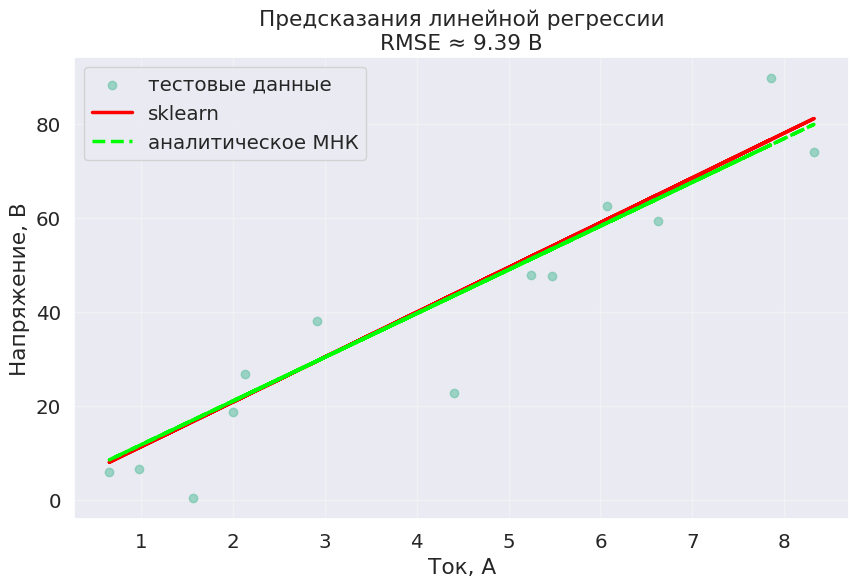

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, alpha=0.6, label='тестовые данные')
plt.plot(X_test, y_pred_sklearn, 'r-', lw=2.5, label='sklearn')
plt.plot(X_test, y_pred_analytic, '--', color='lime', lw=2.5, label='аналитическое МНК')
plt.xlabel('Ток, А')
plt.ylabel('Напряжение, В')
plt.title(f'Предсказания линейной регрессии\nRMSE ≈ {rmse_sklearn:.2f} В')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Задания для самостоятельной работы

1. Добавьте в модель второй признак — I² (квадрат тока). Как изменится качество?
2. Сгенерируйте заведомо нелинейную зависимость (например V = 3·I² + 2·I + шум) и посмотрите, чему научится линейная модель.
3. Реализуйте функцию градиентного спуска для линейной регрессии самостоятельно и сравните с аналитическим решением.
4. Что произойдёт, если сильно увеличить уровень шума (scale noise)?

###Загрузка данных
Датасет содержит ежедневные наблюдения с метеостанций за 1940–1945 годы.
Основные файлы:
- `Summary of Weather.csv` — основной файл с погодными данными
- `Weather Station Locations.csv` — координаты станций (можно присоединить позже)

In [9]:
!curl -L -o weatherww2.zip https://www.kaggle.com/api/v1/datasets/download/smid80/weatherww2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1685k  100 1685k    0     0  7983k      0 --:--:-- --:--:-- --:--:-- 7983k


In [10]:
!unzip -o weatherww2.zip

Archive:  weatherww2.zip
  inflating: Summary of Weather.csv  
  inflating: Weather Station Locations.csv  


In [168]:
df1 = pd.read_csv('Summary of Weather.csv')
df2 = pd.read_csv('Weather Station Locations.csv')

/tmp/ipython-input-1071644818.py:1: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('Summary of Weather.csv')


### Первый осмотр данных

Посмотрим:
- сколько строк и столбцов
- типы данных
- очевидные пропуски
- примеры значений

In [169]:
print("Информация о таблице:")
df1.info()

print("\nКоличество пропусков по столбцам:")
print(df1.isna().mean().sort_values(ascending=False))

print("\nОсновные статистики:")
df1.describe(include='all').T

Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  object 
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SN

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
STA,119040.0,NaN,NaN,NaN,29659.435795,20953.209402,10001.0,11801.0,22508.0,33501.0,82506.0
Date,119040,2192,1945-4-24,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precip,119040,540,0,64267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WindGustSpd,532.0,NaN,NaN,NaN,37.774534,10.297808,18.52,29.632,37.04,43.059,75.932
MaxTemp,119040.0,NaN,NaN,NaN,27.045111,8.717817,-33.333333,25.555556,29.444444,31.666667,50.0
MinTemp,119040.0,NaN,NaN,NaN,17.789511,8.334572,-38.333333,15.0,21.111111,23.333333,34.444444
MeanTemp,119040.0,NaN,NaN,NaN,22.411631,8.297982,-35.555556,20.555556,25.555556,27.222222,40.0
Snowfall,117877.0,42.0,0.0,86090.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PoorWeather,34237,39,1,25846,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YR,119040.0,NaN,NaN,NaN,43.805284,1.136718,40.0,43.0,44.0,45.0,45.0


In [170]:
df1.head(5)

,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
print("Информация о таблице:")
df2.info()

print("\nКоличество пропусков по столбцам:")
print(df2.isna().mean().sort_values(ascending=False))

print("\nОсновные статистики:")
df2.describe(include='all').T

Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WBAN              161 non-null    int64  
 1   NAME              161 non-null    object 
 2   STATE/COUNTRY ID  161 non-null    object 
 3   LAT               161 non-null    object 
 4   LON               161 non-null    object 
 5   ELEV              161 non-null    int64  
 6   Latitude          161 non-null    float64
 7   Longitude         161 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 10.2+ KB

Количество пропусков по столбцам:
WBAN                0.0
NAME                0.0
STATE/COUNTRY ID    0.0
LAT                 0.0
LON                 0.0
ELEV                0.0
Latitude            0.0
Longitude           0.0
dtype: float64

Основные статистики:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
WBAN,161.0,NaN,NaN,NaN,33421.440994,20826.534394,10001.0,13601.0,32906.0,34150.0,82506.0
NAME,161,159,SAN JOSE,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATE/COUNTRY ID,161,64,IY,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAT,161,157,2616N,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LON,161,158,08008W,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELEV,161.0,NaN,NaN,NaN,439.850932,1745.422339,1.0,9.0,27.0,98.0,9999.0
Latitude,161.0,NaN,NaN,NaN,20.347205,21.042992,-27.6,8.233333,22.333333,36.116667,67.016667
Longitude,161.0,NaN,NaN,NaN,8.364182,87.420419,-175.0,-60.85,9.083333,67.25,177.366667


In [172]:
df2.head(5)

,WBAN,NAME,STATE/COUNTRY ID,LAT,LON,ELEV,Latitude,Longitude
0,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.650000
1,33031,LA SENIA,AL,3537N,00037E,88,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,3643N,00314E,23,36.716667,3.216667
3,33044,TELERGMA,AL,3607N,00621E,754,36.116667,6.416667
4,12001,TINDOUF,AL,2741N,00809W,443,27.683333,-8.083333


### Выбираем реально полезные столбцы

В датасете очень много столбцов, но большинство либо почти пустые, либо дублируют информацию.

Оставим только те, которые:
- имеют физический смысл
- заполнены хотя бы на 30–40%

In [173]:
df1_isna = df1.isna().mean()
drop_columns = list(df1_isna[df1_isna > 0.4].index)

print('\nКолонки для удаления:' , drop_columns)

df1.drop(drop_columns, axis=1, inplace=True)


Колонки для удаления: ['WindGustSpd', 'PoorWeather', 'DR', 'SPD', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']


In [174]:
df1.head(5)

,STA,Date,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,PRCP,MAX,MIN,MEA,SNF
0,10001,1942-7-1,1.016,25.555556,22.222222,23.888889,0.0,42,7,1,0.04,78.0,72.0,75.0,0.0
1,10001,1942-7-2,0,28.888889,21.666667,25.555556,0.0,42,7,2,0,84.0,71.0,78.0,0.0
2,10001,1942-7-3,2.54,26.111111,22.222222,24.444444,0.0,42,7,3,0.1,79.0,72.0,76.0,0.0
3,10001,1942-7-4,2.54,26.666667,22.222222,24.444444,0.0,42,7,4,0.1,80.0,72.0,76.0,0.0
4,10001,1942-7-5,0,26.666667,21.666667,24.444444,0.0,42,7,5,0,80.0,71.0,76.0,0.0


В этом датасете будем предсказывать минимальную температуру

Среди признаков нам встретятся как вещественные, так и категориальные. Пока что выделим в качестве категориальных те, значениями которых являются не числа, а какие-то другие сущности. Но имейте в виду, что численные с виду признаки тоже могут быть категориальными.

In [175]:
target_column = df1['MeanTemp']

continuous_columns = [key for key in df1.keys() if df1[key].dtype in ("int64", "float64") and key not in ['MeanTemp', 'Date']]
categorical_columns = [key for key in df1.keys() if df1[key].dtype == "object" and key not in ['Date']]

print(f"Continuous : {len(continuous_columns)}, Categorical : {len(categorical_columns)}")

Continuous : 9, Categorical : 4


Для дальнейшей работы облегчим себе жизнь и обрежем данные, а также приведем некоторые колонки к нужному типу

In [176]:
df1['Date'] = pd.to_datetime(df1['Date'])
df = df1.sample(10000).sort_values('Date')

Чтобы лучше понять, как связаны между собой вещественные признаки, построим матрицу совместных распределений с помощью <a href="https://miptstats.github.io/courses/python/09_seaborn.html#6.-PairGrid">`PairGrid`</a>
При этом разобьём точки и плотности по значениям одного из категориальных признаков — так сразу станет видно, как категория влияет на поведение числовых переменных.

Что мы увидим на графике:

* scatter plot (точки) — реальные пары значений для каждой комбинации двух вещественных признаков,
* двумерные KDE — сглаженная оценка плотности совместного распределения,
* диагональные графики — одномерные ядерные оценки плотности каждого признака в отдельности.

In [177]:
categorical_columns

['Precip', 'Snowfall', 'PRCP', 'SNF']

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect co

IndexError: cannot do a non-empty take from an empty axes.

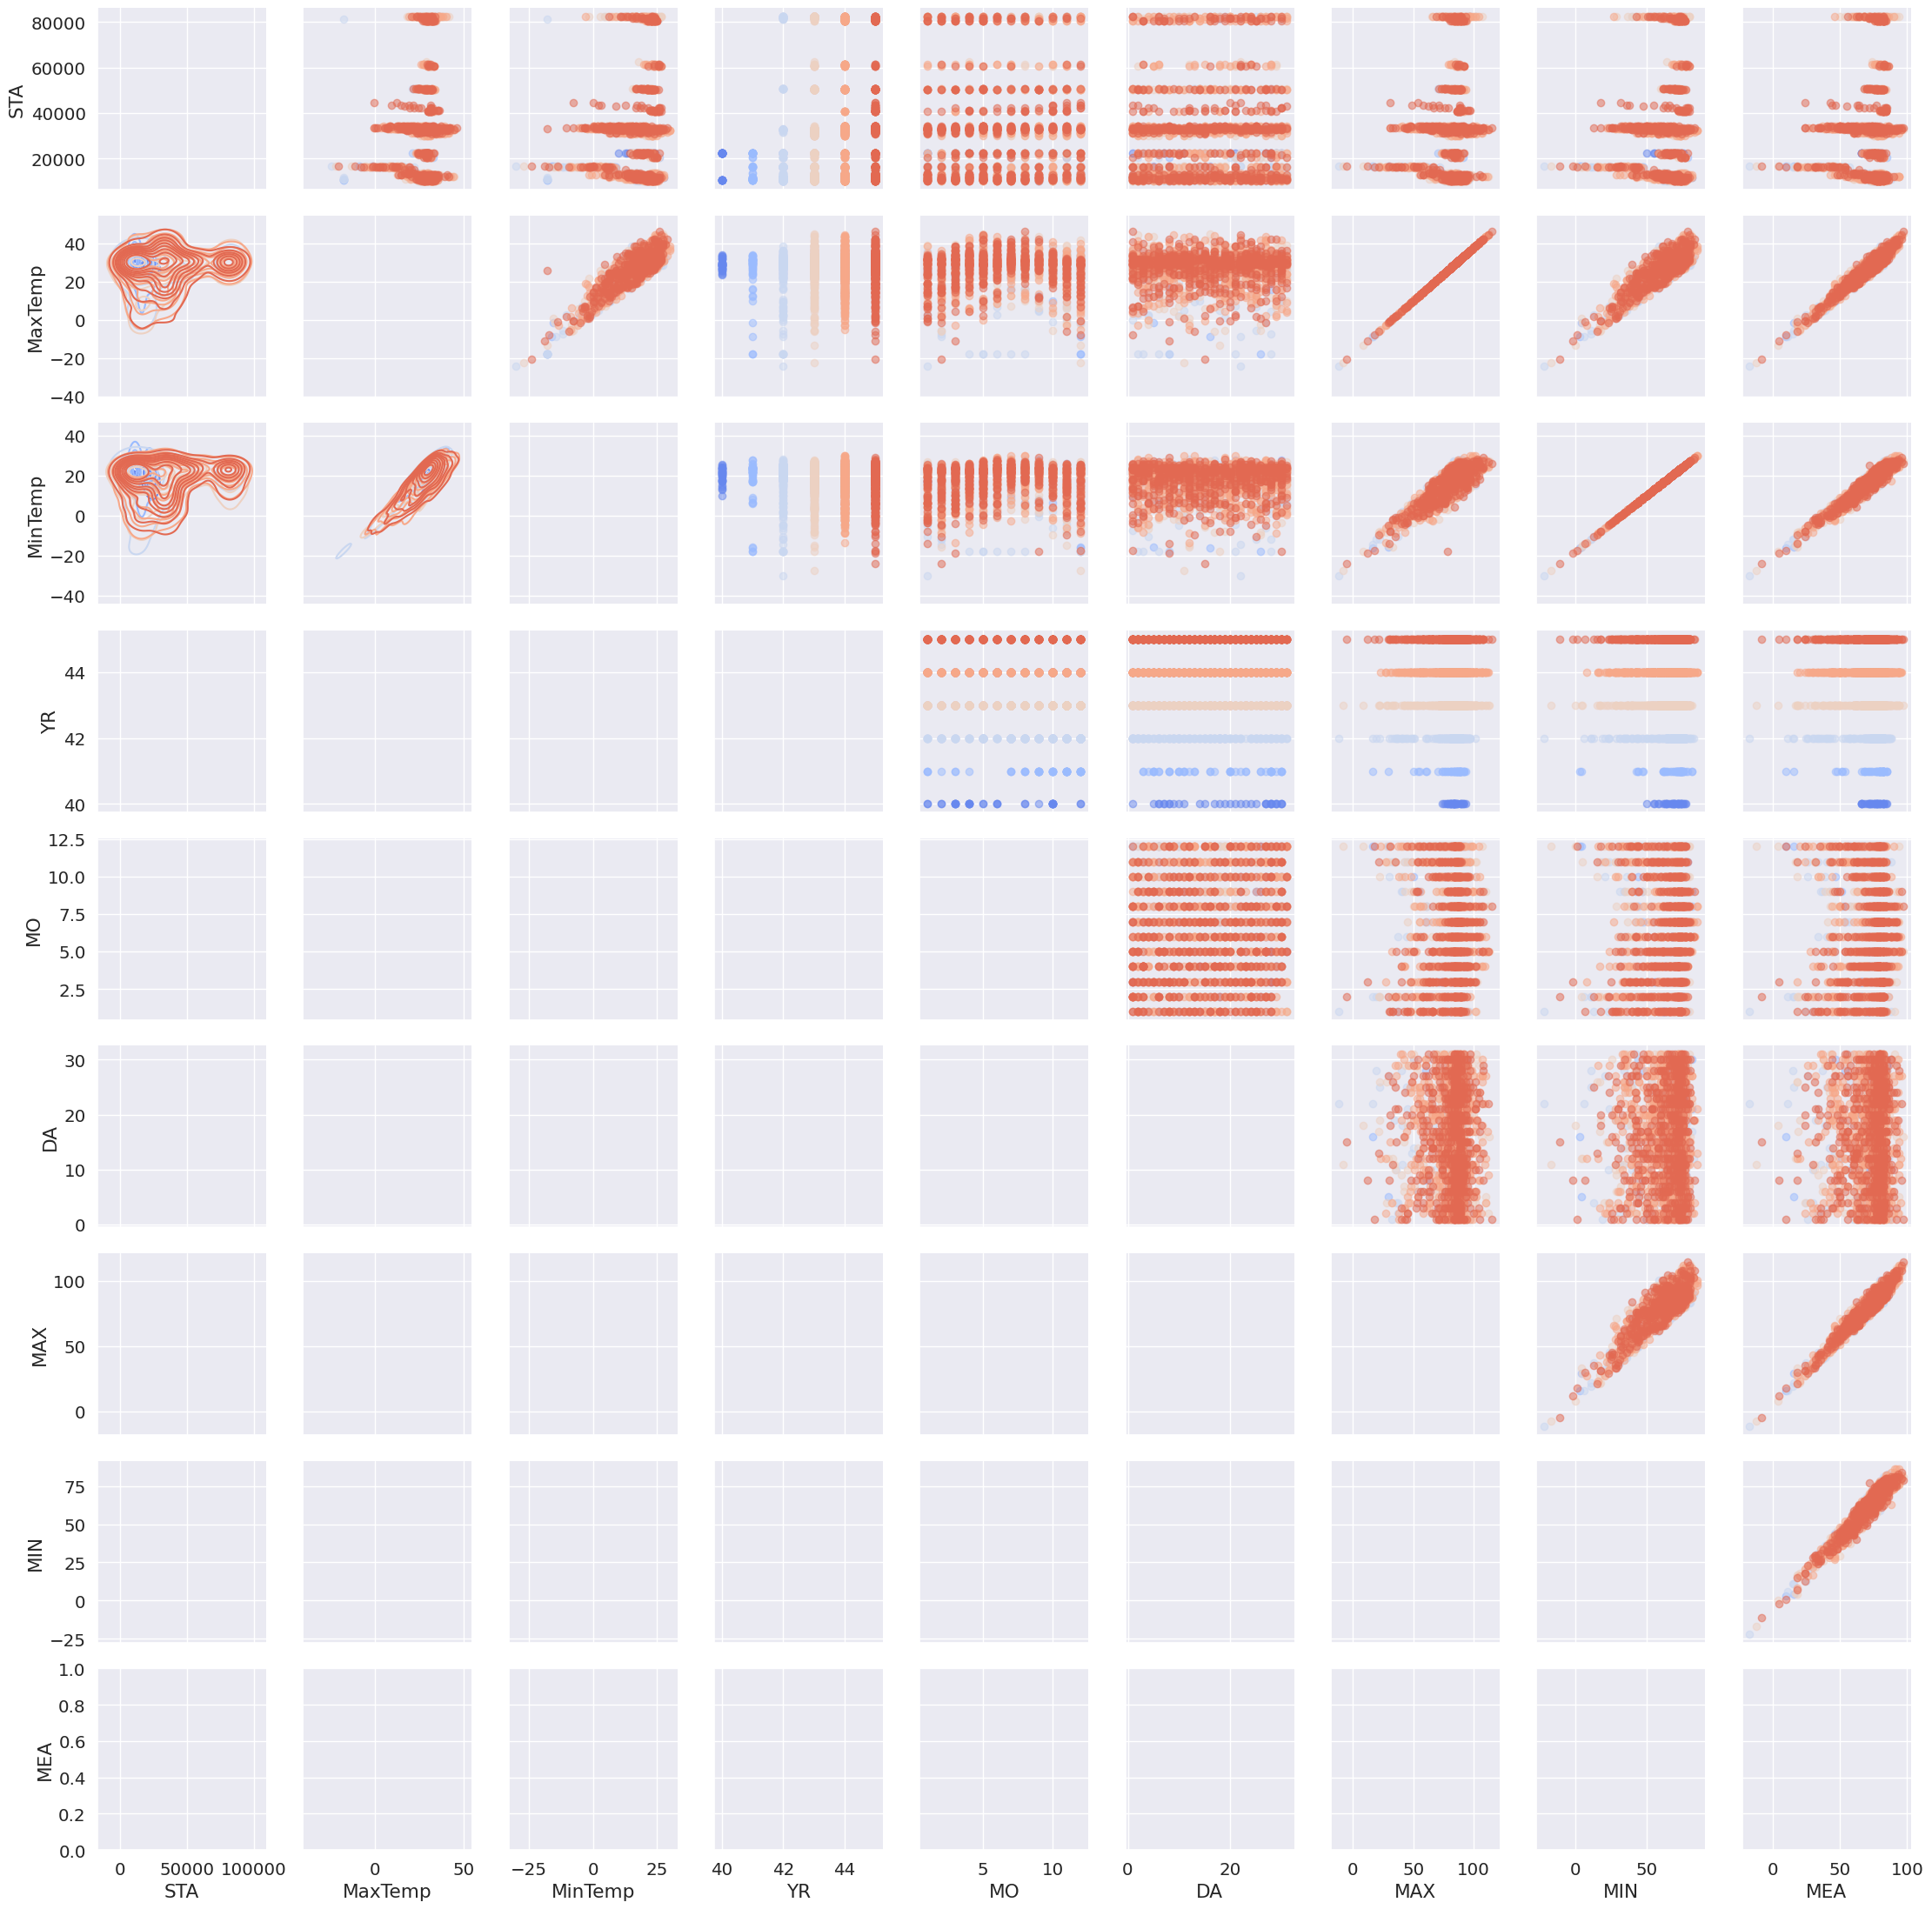

In [178]:
# Before PairGrid, create a categorical year column for better hue grouping
# Increase sample size to provide more data points for KDE estimation
temp_train = df.sample(2000, random_state=42).sort_values('Date') # Increased sample size
temp_train['YR_str'] = temp_train['YR'].astype(str) # Convert year to string to treat as categorical

# Identify years with insufficient data for KDE and filter them out
year_counts = temp_train['YR_str'].value_counts()
years_to_keep = year_counts[year_counts >= 10].index # Keep years with at least 10 data points
temp_train_filtered = temp_train[temp_train['YR_str'].isin(years_to_keep)]

sns.PairGrid(
    temp_train_filtered, # Use the filtered DataFrame
    vars=continuous_columns,
    hue='YR_str', # Use the new categorical year column as hue
    palette='coolwarm'
).map_upper(plt.scatter, alpha=0.5)\
 .map_lower(sns.kdeplot)\
 .map_diag(sns.kdeplot, lw=2)\
 .add_legend()

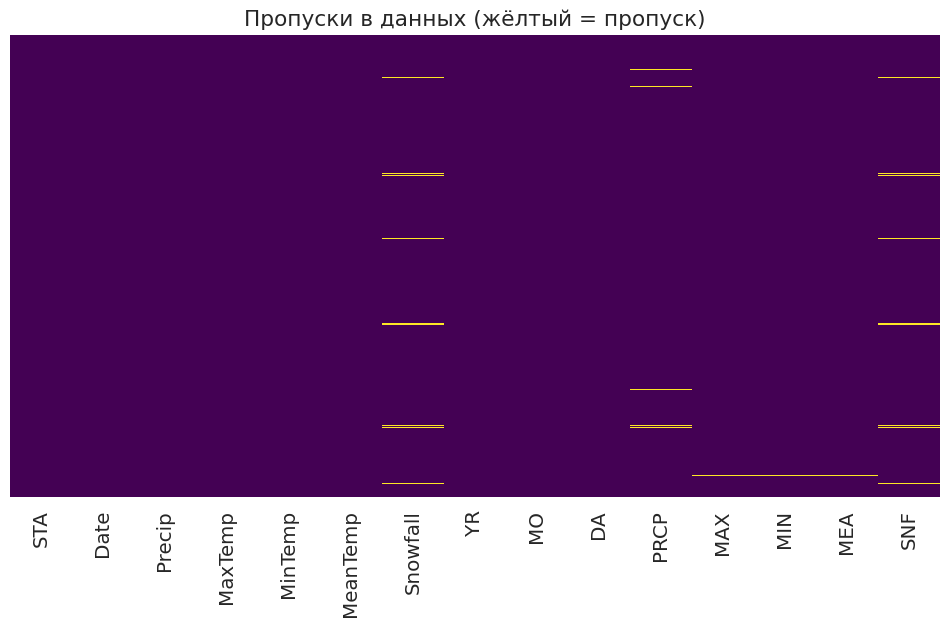

In [179]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Пропуски в данных (жёлтый = пропуск)')
plt.show()

### Стратегии обработки пропусков

Варианты (выбирайте в зависимости от задачи):
1. Удалить строки
2. Заполнить средним/медианой по станции
3. Интерполяция по времени внутри станции
4. Заполнить значением предыдущего дня

In [180]:
df['Precip'].unique()

array(['0', '37.338', 'T', '1.016', '19.304', '4.572', '10.16', '18.796',
       '1.524', '3.81', '15.494', '0.254', '2.286', '33.528', '18.542',
       '1.27', '11.176', '2.032', '8.128', '27.94', '9.398', '4.318',
       '0.762', '6.35', '26.416', '2.54', '3.048', '7.62', '30.48',
       '184.404', '1.778', '5.334', '2.794', '10.414', '0.508', '23.368',
       '4.064', '8.382', '11.938', '24.638', '5.08', '41.402', '20.066',
       '26.162', '6.858', '44.958', '8.89', '97.79', '59.69', '9.652',
       '3.302', '6.096', '26.924', '10.668', '7.112', '4.826', '7.366',
       '12.192', '17.272', '6.604', '25.654', '35.306', '29.21', '3.556',
       '14.478', '17.018', '14.224', '24.892', '11.43', '5.842', '25.146',
       '15.748', '12.446', '12.954', '59.182', '45.72', '42.672',
       '154.686', '8.636', '36.576', '13.208', '22.098', '14.732',
       '5.588', '19.05', '13.716', '16.51', '21.082', '97.028', '9.906',
       '36.068', '66.04', '14.986', '19.812', '47.752', '9.144', '92.45

In [181]:
df['Snowfall'].unique()

array(['0', 0.0, '5.08', nan, '2.54', '7.62', '10.16', '12.7', '17.78',
       '20.32', '38.1', '25.4', '33.02', '48.26', '#VALUE!', '27.94',
       '22.86', '15.24', '30.48', '63.5', '60.96', '35.56', '45.72',
       '40.64', '43.18', 2.54, 7.62], dtype=object)

In [182]:
df['SNF'].unique()

array(['0', 0.0, '0.2', nan, '0.1', '0.3', '0.4', '0.5', '0.7', '0.8',
       '1.5', '1', '1.3', '1.9', 'T', '1.1', '0.9', '0.6', '1.2', '2.5',
       '2.4', '1.4', '1.8', '1.6', '1.7', 0.1, 0.3], dtype=object)

In [183]:
print("До очистки пропусков:")
print(df.isna().mean().sort_values(ascending=False).head(10))
df['Precip'] = df['Precip'].replace('T', '0.01').astype(float)
df['Snowfall'] = df['Snowfall'].replace('#VALUE!', '0.01').astype(float)
df['SNF'] = df['SNF'].replace('T', '0.01').astype(float)
df['PRCP'] = df['SNF'].replace('T', '0.01').astype(float)

df['PRCP'] = df['PRCP'].replace(np.nan, df['PRCP'].astype(float).mean())
df['Snowfall'] = df['Snowfall'].replace(np.nan, 0.01)
df['MAX'] = df['MAX'].replace(np.nan, df['MAX'].astype(float).max())
df['MIN'] = df['MIN'].replace(np.nan, df['MIN'].astype(float).min())
df['MEA'] = df['MEA'].replace(np.nan, df['MEA'].astype(float).mean())
df['SNF'] = df['SNF'].replace(np.nan, 0)
print("После очистки пропусков:")
print(df.isna().mean().sort_values(ascending=False).head(10))

До очистки пропусков:
PRCP        0.0183
SNF         0.0095
Snowfall    0.0095
MEA         0.0039
MIN         0.0038
MAX         0.0038
Date        0.0000
MeanTemp    0.0000
MinTemp     0.0000
MaxTemp     0.0000
dtype: float64
После очистки пропусков:
STA         0.0
Date        0.0
Precip      0.0
MaxTemp     0.0
MinTemp     0.0
MeanTemp    0.0
Snowfall    0.0
YR          0.0
MO          0.0
DA          0.0
dtype: float64


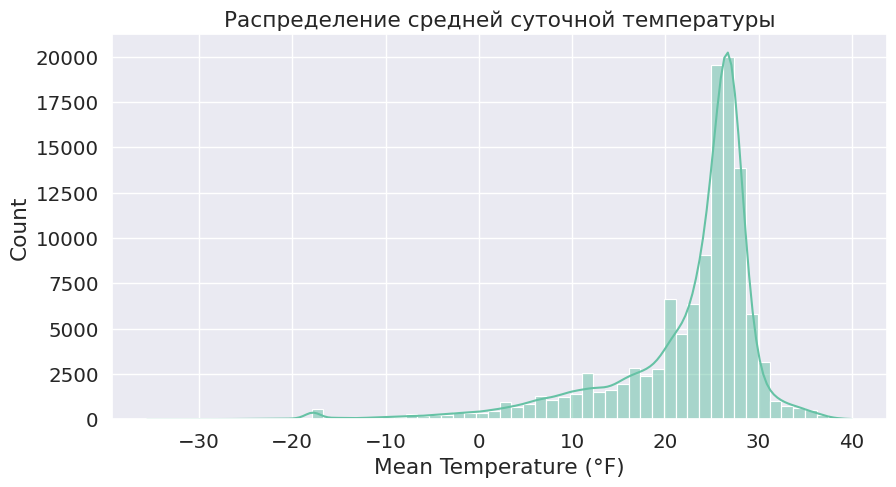

In [184]:
plt.figure(figsize=(10, 5))
sns.histplot(target_column, bins=60, kde=True)
plt.title('Распределение средней суточной температуры')
plt.xlabel('Mean Temperature (°F)')
plt.show()

In [185]:
# Разница температур день/ночь
df['temp_range'] = df['MaxTemp'] - df['MinTemp']

# Признак сезона
df['season'] = df['MO'].map({
    12:'winter', 1:'winter', 2:'winter',
    3:'spring', 4:'spring', 5:'spring',
    6:'summer', 7:'summer', 8:'summer',
    9:'autumn',10:'autumn',11:'autumn'
})

# Бинарный признак — были осадки
df['rained'] = (df['PRCP'] > 0).astype(int)

df[['Date','STA','MaxTemp','temp_range','rained','season']].sample(8)

,Date,STA,MaxTemp,temp_range,rained,season
74245,1944-08-05,32803,30.555556,6.111111,0,summer
15203,1945-11-14,10803,31.111111,7.777778,0,autumn
9519,1943-12-13,10704,28.888889,6.666667,0,winter
88628,1945-12-26,33405,16.111111,12.222222,0,winter
90982,1945-10-28,34018,20.000000,7.222222,0,autumn
74089,1944-03-01,32803,32.777778,15.000000,0,spring
84552,1944-11-22,33117,17.222222,5.555556,0,autumn
58851,1942-09-01,22508,27.222222,7.222222,0,autumn


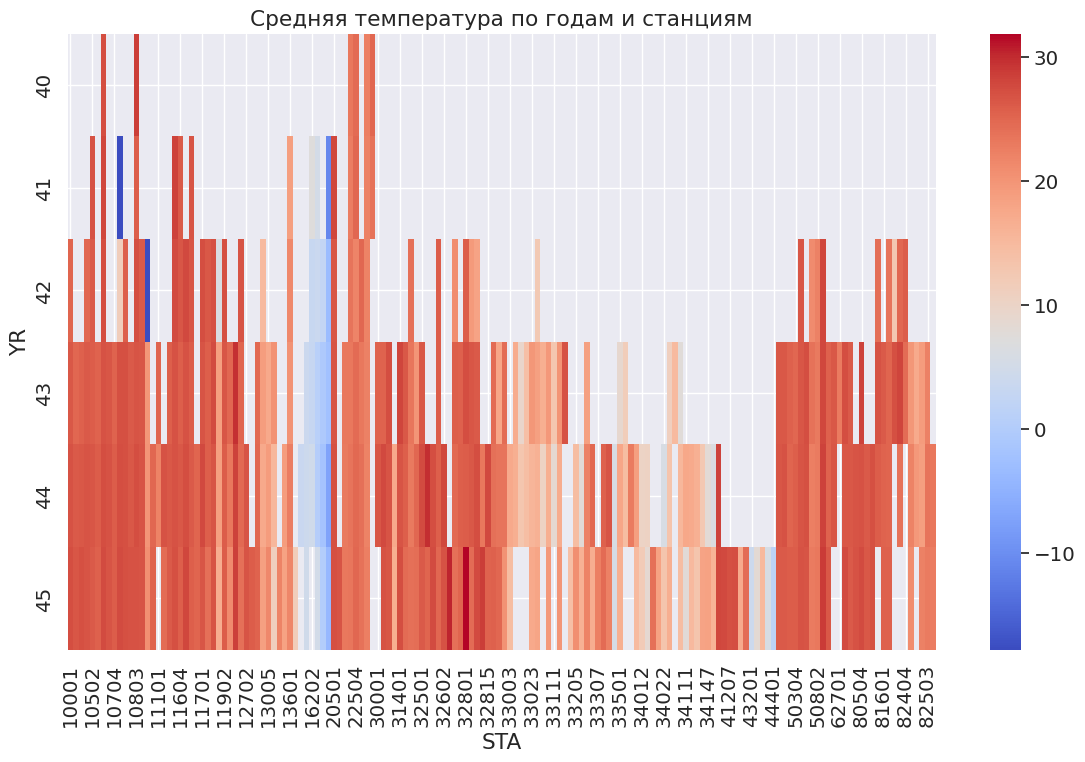

In [186]:
# Средняя температура по годам и станциям
year_station_temp = df.groupby(['YR', 'STA'])['MeanTemp'].mean().unstack()

plt.figure(figsize=(14, 8))
sns.heatmap(year_station_temp, cmap='coolwarm')
plt.title('Средняя температура по годам и станциям')
plt.show()

## Важные особенности линейной регрессии

Линейная регрессия имеет две важные характеристики, о которых полезно помнить:

1. **Она работает только с числовыми (вещественными) признаками**  
   Категориальные переменные (пол, регион, да/нет и т.п.) модель напрямую использовать не умеет.  
   Поэтому приходится либо игнорировать такие признаки, либо преобразовывать их в числа (самый простой вариант на старте — просто отбросить).

2. **Чувствительность к масштабу признаков**  
   Если один признак измеряется в метрах, а другой — в миллионах, то коэффициенты при «больших» признаках будут сильно штрафоваться при использовании регуляризации (Ridge, Lasso и др.).  
   Чтобы этого избежать, признаки обычно приводят к **единому масштабу** (нормализуют / стандартизируют).

### Основные способы масштабирования в `sklearn`

| Класс                        | Что делает                                                                 | Когда удобнее использовать                  |
|------------------------------|----------------------------------------------------------------------------|---------------------------------------------|
| `StandardScaler`             | Вычитает среднее и делит на стандартное отклонение → распределение ~ N(0,1) | Градиентный спуск, регуляризованные модели  |
| `MinMaxScaler`               | Приводит значения в диапазон [0, 1] (или другой заданный)                  | Нейронные сети, алгоритмы, чувствительные к границам |

### Правильный порядок применения (очень важно!)

```python
from sklearn.preprocessing import StandardScaler

# создаём и настраиваем на обучающей выборке
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# применяем уже обученный scaler к тестовой выборке
X_test_scaled  = scaler.transform(X_test)

In [201]:
target_column = df['MeanTemp']

continuous_columns = [key for key in df.keys() if df[key].dtype in ("int64", "float64") and key not in ['MeanTemp'] and not key.isupper()]
categorical_columns = [key for key in df.keys() if df[key].dtype == "object" and key not in ['Date']]

print(f"Continuous : {len(continuous_columns)}, Categorical : {len(categorical_columns)}")

Continuous : 6, Categorical : 1


In [203]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# month лучше сделать категориальным (или one-hot)
df['MO'] = df['MO'].astype('category')
df = df[continuous_columns + categorical_columns + ['MeanTemp']]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
    ]
)

print("Размер данных для моделирования:", df.shape)
print(df.head(3))

Размер данных для моделирования: (10000, 8)
       Precip    MaxTemp    MinTemp  Snowfall  temp_range  rained  season  \
54505   0.000  26.666667  16.666667       0.0   10.000000       0  winter   
57883  37.338  24.444444  16.666667       0.0    7.777778       0  winter   
6299    0.000  31.666667  22.777778       0.0    8.888889       0  winter   

        MeanTemp  
54505  21.666667  
57883  20.555556  
6299   27.222222  


Часть данных пойдет на обучение, а часть на проверку, для этого разделим данные

In [204]:
train, test = train_test_split(df, test_size=0.2)
train.shape, test.shape

((8000, 8), (2000, 8))

In [205]:
X_train = train.drop('MeanTemp', axis=1)
y_train = train['MeanTemp']

X_test  = test.drop('MeanTemp', axis=1)
y_test  = test['MeanTemp']

In [206]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Полный пайплайн: предобработка + модель
model_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Обучаем
model_pipe.fit(X_train, y_train)

# Предсказания
y_pred_train = model_pipe.predict(X_train)
y_pred_test  = model_pipe.predict(X_test)

# Метрики
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test,  y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test,  y_pred_test)

print("Результаты линейной регрессии")
print(f"Train → RMSE: {rmse_train:.3f}    R^2: {r2_train:.4f}")
print(f"Test → RMSE: {rmse_test:.3f}    R^2: {r2_test:.4f}")

Результаты линейной регрессии
Train → RMSE: 0.408    R^2: 0.9976
Test → RMSE: 0.227    R^2: 0.9991


In [207]:
# Получаем имена признаков после one-hot
feature_names = (
    continuous_columns +
    list(model_pipe.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_columns))
)

# Коэффициенты
coefs = model_pipe.named_steps['regressor'].coef_
intercept = model_pipe.named_steps['regressor'].intercept_

print("Intercept (свободный член):", round(intercept, 3))
print("\nКоэффициенты:")
for name, coef in zip(feature_names, coefs):
    print(f"{name:>12} : {coef:>8.4f}")

Intercept (свободный член): 22.319

Коэффициенты:
      Precip :   0.0051
     MaxTemp :   4.2463
     MinTemp :   4.3929
    Snowfall :  -0.0064
  temp_range :   0.0849
      rained :   0.0131
season_spring :   0.0066
season_summer :   0.0055
season_winter :   0.0015


### Самостоятельная работа
Вы ее ждали и вот она
1) Выберите 4–6 признаков, которые, по-вашему, лучше всего подойдут для предсказания meantemp.
Например: mintemp, maxtemp, prcp, snowfall, month, year.
Обоснуйте выбор (физический смысл, корреляции из PairGrid)

2) Выберите признаки, которые не относятся напрямую к температурным, постройте регрессию и проанализируйте коэффициенты: как поменялось соотношение? Что стало главным?

3) Постройте регрессию без свободного члена (о том, как это сделать посмотрите в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)) и оцените изменения коэффициентов: кто сейчас лидирует? Есть ли в этом физика или просто повезло? Сравните метрики (RMSE, MAE, MAPE, $R^2$) между моделью с intercept и без.

На все пункты предоставьте отчеты с графиками если можно или с полным описанием что как и почему изменилось.

### Домашняя работа
Задача: Повторите анализ и предсказание на классическом датасете из библиотеки sklearn .

Импортируйте датасет [california housing](https://scikit-learn.org/1.1/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing).

Описание: предсказание цены жилья по признакам (комнаты, расстояние до центра, уровень преступности и т.д.).

Выполните препроцессинг:
* Отбор 4–6 признаков (посмотрите корреляции)
* Обработка пропусков (если есть)
* Масштабирование

Обучите линейную регрессию:
* С intercept и без
* Сравните метрики (RMSE, MAE, MAPE, R²)

Добавьте полиномиальные признаки и переобучите.
Улучшилось ли качество? Есть ли переобучение?

In [209]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
df = data.frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
